In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


To run this notebook, you will need a copy of the LOSC event tutorial.  You can get a version by uncommenting and running the cell below; it is also included with this repository in git lfs storage.

In [2]:
#!wget https://losc.ligo.org/s/events/LOSC_Event_tutorial.zip
!openssl md5 LOSC_Event_tutorial.zip
#!unzip LOSC_Event_tutorial.zip

MD5(LOSC_Event_tutorial.zip)= 7ba4224fc8387fb0d1e958b729e67850


In [3]:
import sys

try:
    sys.path.index('./LOSC_Event_tutorial')
except:
    sys.path.append('./LOSC_Event_tutorial')

import h5py
import json
import os.path as op
import readligo as rl 
import scipy.interpolate as si
import scipy.signal as ss

## Python Functions For Padding, Time-, Phase-, and Amplitude-Shifting Waveforms, etc

First, a few useful functions for time-, phase-, and amplitude-shifting waveforms.

In [4]:
def pad(xs, nmin):
    """Pad the array `xs` with zeros to be a power of two at least as large as `nmin`. """
    npad = 1
    while npad < nmin:
        npad = npad << 1
        
    xspad = zeros(npad)
    xspad[:xs.shape[0]] = xs
    
    return xspad

In [5]:
def timephaseamp_shift(ts, xs, dt, dphi, A):
    """Return an array like `xs`, but shifted in time by `dt`, phase by `dphi`, and amplitude by `A`.
    
    The array will be zero-padded to avoid wrap-around *as long as `dt < ts[-1]-ts[0]`*.
    """
    
    nxs = xs.shape[0]
    xspad = pad(xs, 2*nxs)
    npad = xspad.shape[0]
    fs = np.fft.rfftfreq(npad, ts[1]-ts[0])
    xsfreq = np.fft.rfft(xspad)
    
    shift_xsfreq = A*exp(-2.0*pi*1j*fs*dt)*exp(-1j*dphi)*xsfreq
    
    shift_xspad = np.fft.irfft(shift_xsfreq)
    
    return shift_xspad[:nxs]

In [6]:
def cplx_snr_timeseries(data, template, template_cross=None):
    """Return the complex SNR time series for the data and given template
    
    The complex SNR timeseries for data ``d`` and template ``h`` is defined 
    by the inner product ``csnr = < d | h > / sqrt(< h | h>)``,  where ``< a | b >`` is 
    ``<a | b > = sum(conj(a[f])*b[f])``.
    """
    assert data.shape[0] == template.shape[0]
    
    nd = data.shape[0]
    
    data_pad = pad(data, 2*nd)
    template_pad = pad(template, 2*nd)
    
    if template_cross is None:
        template_cross_pad = np.fft.irfft(1j*np.fft.rfft(template_pad)) # Pi/2 phase shift, the "sine" like part
    else:
        template_cross_pad = pad(template_cross, 2*nd)
        
    cplx_template_pad = template_pad + 1j*template_cross_pad
    
    cplx_template_freq = np.fft.fft(cplx_template_pad)

    # Normalise template to unit vector
    cplx_template_freq /= np.sqrt(np.real(np.sum(cplx_template_freq*np.conj(cplx_template_freq))))
    
    csnr = np.fft.ifft(np.fft.fft(data_pad)*np.conj(cplx_template_freq))    
    
    return csnr

In [122]:
def index_of_max_snr(snr_tseries):
    """Returns the (fractional) index of the maximum amplitude in the SNR series, using quadratic interpolation.
    
    """
    
    snr = np.abs(snr_tseries)
    m = argmax(snr)
    l = m-1
    h = m+1
    
    sm = snr[m]
    sl = snr[l]
    sh = snr[h]
    
    return (m**2*(sh-sl) + h**2*(sl-sm) + l**2*(sm-sh))/(2*(m*(sh-sl) + h*(sl-sm) + l*(sm-sh)))

In [111]:
def inner_product(A, B):
     nd = A.shape[0]
    
     A_pad = pad(A, nd) # We don't need any zero-padding, but this gets us to a power of 2
     B_pad = pad(B, nd)
    
     return np.sum(np.fft.fft(A_pad)*np.conj(np.fft.fft(B_pad)))

## Download the Data

We will be downloading Figure data from https://losc.ligo.org/events/GW150914/ (this is the infamous "Figure 1").  It is included in this repository, but if you want to download it, uncomment the relevant lines and execute the cell.

In [112]:
#!wget https://losc.ligo.org/s/events/GW150914/P150914/fig1-observed-H.txt
!openssl md5 fig1-observed-H.txt
#!wget https://losc.ligo.org/s/events/GW150914/P150914/fig1-observed-L.txt
!openssl md5 fig1-observed-L.txt
#!wget https://losc.ligo.org/s/events/GW150914/P150914/fig1-waveform-H.txt
!openssl md5 fig1-waveform-H.txt
#!wget https://losc.ligo.org/s/events/GW150914/P150914/fig1-waveform-L.txt
!openssl md5 fig1-waveform-L.txt

MD5(fig1-observed-H.txt)= 6f3f3005f6c3a7e3b74f8fc9839420de
MD5(fig1-observed-L.txt)= 3c5e9e926193b80e1d6f97167af933fd
MD5(fig1-waveform-H.txt)= 83e670f94d361eae9e4bbda59dceab66
MD5(fig1-waveform-L.txt)= 7e601d48e9b87f8502913830d5995363


Load the data:

In [113]:
h1data = genfromtxt('fig1-observed-H.txt')
l1data = genfromtxt('fig1-observed-L.txt')
h1wf = genfromtxt('fig1-waveform-H.txt')
l1wf = genfromtxt('fig1-waveform-L.txt')

# The h1 and l1 waveforms come timeshifted; since I'm going to timeshift them anyway, I'm going to 
# move them back to start at the same time as the corresponding data stream (everything is 
# sampled at 16 kHz, so we are safe in just shifting).
h1_initial_timeshift = h1data[0,0]-h1wf[0,0]
l1_initial_timeshift = l1data[0,0]-l1wf[0,0]

h1wf[:,0] = h1wf[:,0] + h1_initial_timeshift
l1wf[:,0] = l1wf[:,0] + l1_initial_timeshift

print('h1 timeshift = {:.2g} s'.format(h1_initial_timeshift))
print('l1 timeshift = {:.2g} s'.format(l1_initial_timeshift))

# The H1 waveforms are now one sample shorter than the data, so we'll just cut the data down by one sample
h1data = h1data[:-1,:]
l1data = l1data[:-1,:]
l1wf = l1wf[:-1,:]

h1 timeshift = -5e-05 s
l1 timeshift = -7.8e-06 s


Plot, just for sanity check (ignoring the timeshift):

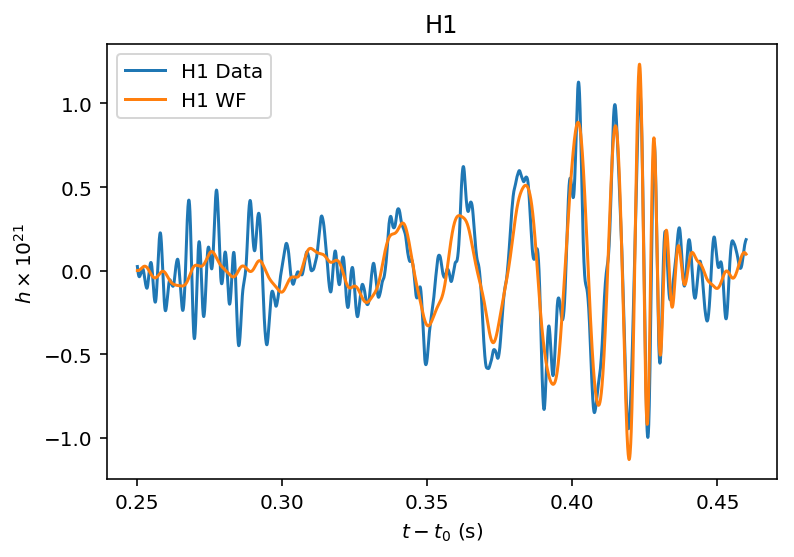

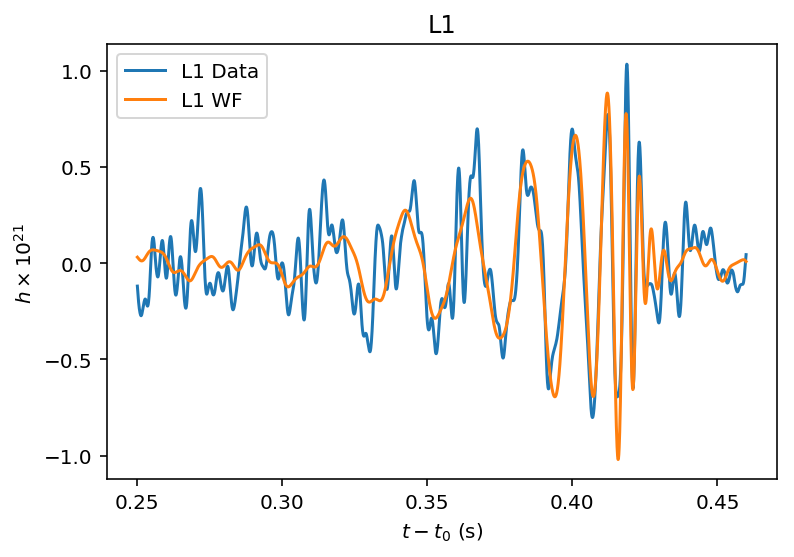

In [114]:
plot(*h1data.T, label='H1 Data')
plot(*h1wf.T, label='H1 WF')
title('H1')
xlabel(r'$t-t_0$ ($\mathrm{s}$)')
ylabel(r'$h \times 10^{21}$')
legend(loc='best')

figure()
title('L1')
plot(*l1data.T, label='L1 Data')
plot(*l1wf.T, label='L1 WF')
xlabel(r'$t-t_0$ ($\mathrm{s}$)')
ylabel(r'$h \times 10^{21}$')
legend(loc='best')

Now let's form some residuals from direct subtraction; since we have not optimised the fit in terms of time, phase, or amplitude, these residuals can be expected to have some "signal" left.  We will check that we recover something like the correlations reported in [Cresswell, et al. (2017)](http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1706.04191).

In [115]:
resh1 = column_stack((h1data[:,0], h1data[:,1]-h1wf[:,1]))
resl1 = column_stack((l1data[:,0], l1data[:,1]-l1wf[:,1]))

Let's copy-paste the code from Creswell, et al. notebook, found [here](http://www.nbi.ku.dk/gravitational-waves/correlations.html).  As expected, there are some correlations in the data as described in Creswell, et al. (2017).

max |corr| = 0.81 at tau = 7.39 ms


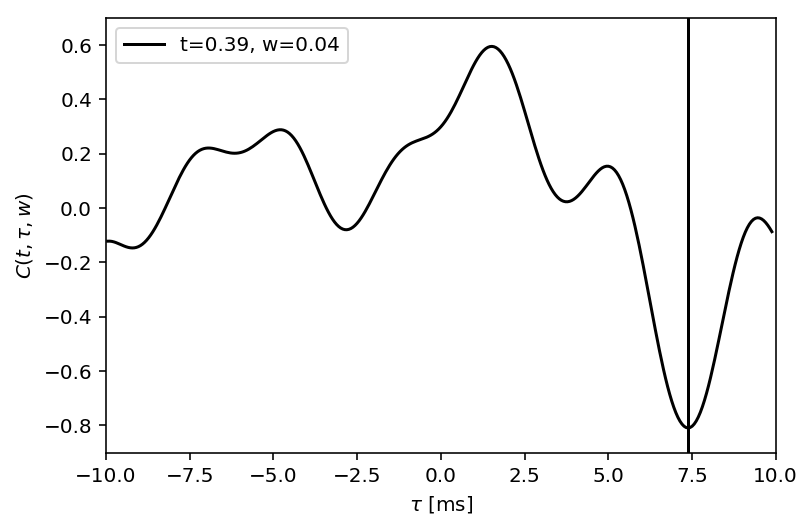

In [116]:
h1_res_times = resh1[:,0]; h1_res_strain = resh1[:,1]
l1_res_times = resl1[:,0]; l1_res_strain = resl1[:,1]

fs = 1./(h1_res_times[1]-h1_res_times[0])

t = 0.39
w = 0.04

min_indxt = np.where(abs(h1_res_times-t) == abs(h1_res_times-t).min())[0][0]
max_indxt = np.where(abs(h1_res_times-(t+w)) == abs(h1_res_times-(t+w)).min())[0][0]

deltatau = 0.01

tauind_min = int(-deltatau*fs); tauind_max = int(+deltatau*fs)
tauind = np.arange(tauind_min,tauind_max)
tau = tauind/fs

corr = []

for i in tauind:
    corr.append(np.corrcoef(h1_res_strain[min_indxt+abs(tauind_min)+i:max_indxt-abs(tauind_max)+i],l1_res_strain[min_indxt+abs(tauind_min):max_indxt-abs(tauind_max)])[0][1])
corr = array(corr)
    
imax = argmax(abs(corr))
print('max |corr| = {:.2g} at tau = {:.3g} ms'.format(max(abs(corr)), 1000*tau[imax]))

plt.figure()
plt.plot(tau * 1000.,corr,'k',label="t="+str(t)+", w="+str(w))
plt.axvline(1000*tau[imax], color='k')
plt.xlim(-10,10)
plt.xlabel(r"$\tau$ [ms]")
plt.ylabel(r"$C(t,\tau,w)$")
plt.ylim(-.9,.7)
plt.legend(loc='best')

Now let's compute the peak of the SNR time series and the phase at the peak:

In [128]:
snrs_h1 = cplx_snr_timeseries(h1data[:,1], h1wf[:,1])
snrs_l1 = cplx_snr_timeseries(l1data[:,1], l1wf[:,1])

The number of samples we need to shift the signal comes from the peak of the SNR time series.

In [129]:
i_h1 = index_of_max_snr(snrs_h1)
i_l1 = index_of_max_snr(snrs_l1)

print('Signal sample shift in H1 = {:.2f} samples'.format(i_h1))
print('Signal sample shift in L1 = {:.2f} samples'.format(i_l1))

dt_h1 = i_h1*(h1data[1,0]-h1data[0,0])
dt_l1 = i_l1*(l1data[1,0]-l1data[0,0])

angles_h1 = si.interp1d(arange(len(snrs_h1)), angle(snrs_h1))
angles_l1 = si.interp1d(arange(len(snrs_l1)), angle(snrs_l1))

phi_h1 = angles_h1(i_h1)
phi_l1 = angles_l1(i_l1)

h1_temp = timephaseamp_shift(h1wf[:,0], h1wf[:,1], dt_h1, phi_h1, 1.0)
l1_temp = timephaseamp_shift(l1wf[:,0], l1wf[:,1], dt_l1, phi_l1, 1.0)

Signal sample shift in H1 = 3.95 samples
Signal sample shift in L1 = 3.02 samples


It looks like a good timeshift.

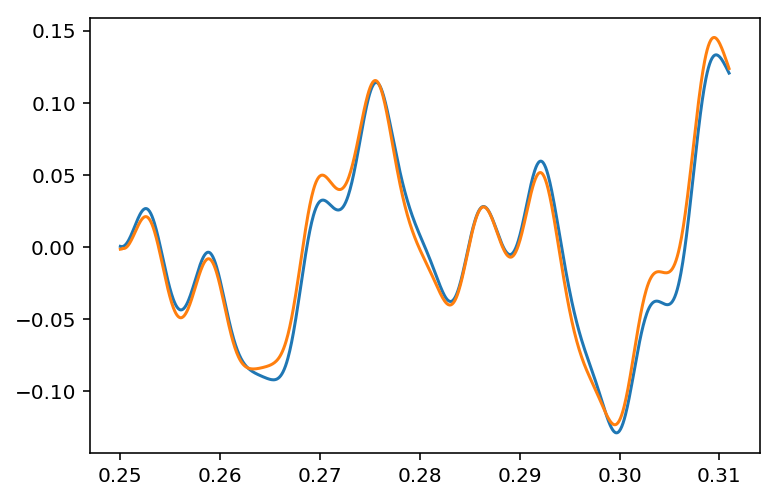

In [130]:
plot(h1wf[:1000,0], h1wf[:1000,1])
plot(h1wf[:1000,0], h1_temp[:1000])

Now to compute the signal amplitude factors, we take the inner product and normalise:

In [131]:
A_h1 = inner_product(h1data[:,1], h1_temp)/inner_product(h1_temp, h1_temp)
A_l1 = inner_product(l1data[:,1], l1_temp)/inner_product(l1_temp, l1_temp)

And we adjust the waveform to match the optimal amplitude, time offset, and phase shift:

In [132]:
h1_adjusted = zeros_like(h1wf)
h1_adjusted[:,0] = h1wf[:,0]
h1_adjusted[:,1] = timephaseamp_shift(h1wf[:,0], h1_temp, 0.0, 0.0, A_h1)

l1_adjusted = zeros_like(l1wf)
l1_adjusted[:,0] = l1wf[:,0]
l1_adjusted[:,1] = timephaseamp_shift(l1wf[:,0], l1_temp, 0.0, 0.0, A_l1)

Here, for posterity, are the relevant amplitude, time, and phase factors to apply to optimize the residuals *for this waveform*.

In [133]:
print('For H1: A = {:.4g}, dt = {:.4g}, phi = {:.4g}'.format(A_h1, dt_h1, phi_h1))
print('For L1: A = {:.4g}, dt = {:.4g}, phi = {:.4g}'.format(A_l1, dt_l1, phi_l1))
print('H1/L1 Amplitude ratio = {:.4g}, dt_H1 - dt_L1 = {:.4g}, phi_H1 - phi_L1 = {:.4g}'.format(A_h1/A_l1, dt_h1-dt_l1, phi_h1-phi_l1))

For H1: A = 0.9352+1.812e-18j, dt = 0.0002408, phi = -0.2413
For L1: A = 0.9176-6.906e-18j, dt = 0.0001842, phi = -0.1266
H1/L1 Amplitude ratio = 1.019+9.646e-18j, dt_H1 - dt_L1 = 5.667e-05, phi_H1 - phi_L1 = -0.1147


Now re-make the plot of all the waveforms:

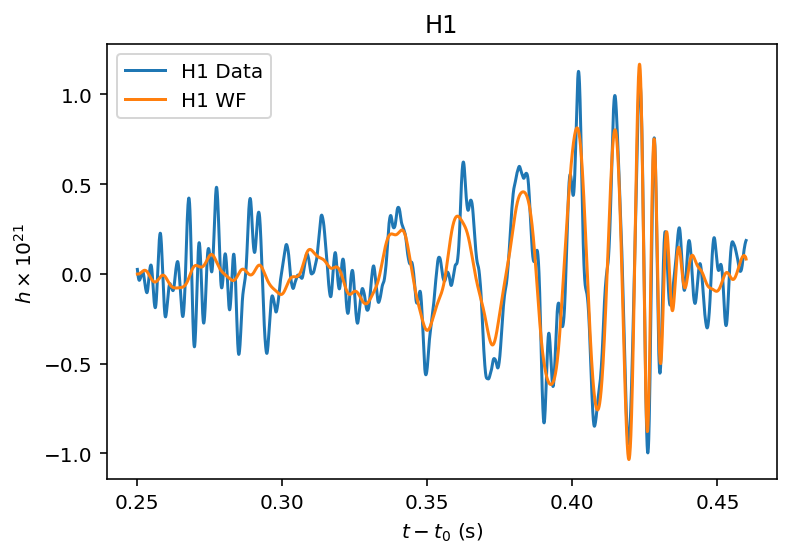

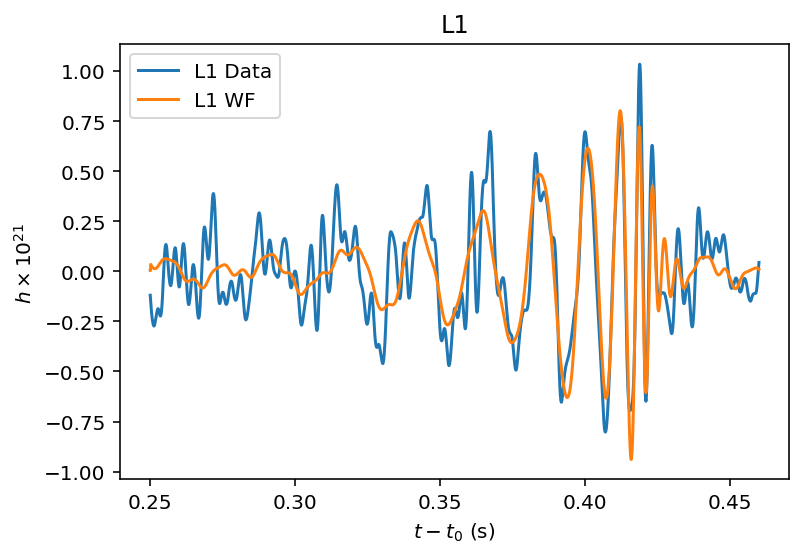

In [134]:
plot(*h1data.T, label='H1 Data')
plot(*h1_adjusted.T, label='H1 WF')
title('H1')
xlabel(r'$t-t_0$ ($\mathrm{s}$)')
ylabel(r'$h \times 10^{21}$')
legend(loc='best')

figure()
title('L1')
plot(*l1data.T, label='L1 Data')
plot(*l1_adjusted.T, label='L1 WF')
xlabel(r'$t-t_0$ ($\mathrm{s}$)')
ylabel(r'$h \times 10^{21}$')
legend(loc='best')

Form the new residuals:

In [135]:
adjusted_resh1 = zeros_like(h1data)
adjusted_resh1[:,0] = h1data[:,0]
adjusted_resh1[:,1] = h1data[:,1] - h1_adjusted[:,1]

adjusted_resl1 = zeros_like(l1data)
adjusted_resl1[:,0] = l1data[:,0]
adjusted_resl1[:,1] = l1data[:,1] - l1_adjusted[:,1]

Let's see whether we have reduced the RSS:

In [136]:
orig_rss = sum(resh1*resh1) + sum(resl1*resl1)
adjusted_rss = sum(adjusted_resh1*adjusted_resh1) + sum(adjusted_resl1*adjusted_resl1)
print('original rss = {:.4g}'.format(orig_rss))
print('adjusted rss = {:.4g}'.format(adjusted_rss))

original rss = 1071
adjusted rss = 1062


And let's look at the correlation plot again; the correlation has been reduced, but not eliminated.  Clearly this template is not a good one for analyzing the data.

max |corr| = 0.65 at tau = 7.32 ms


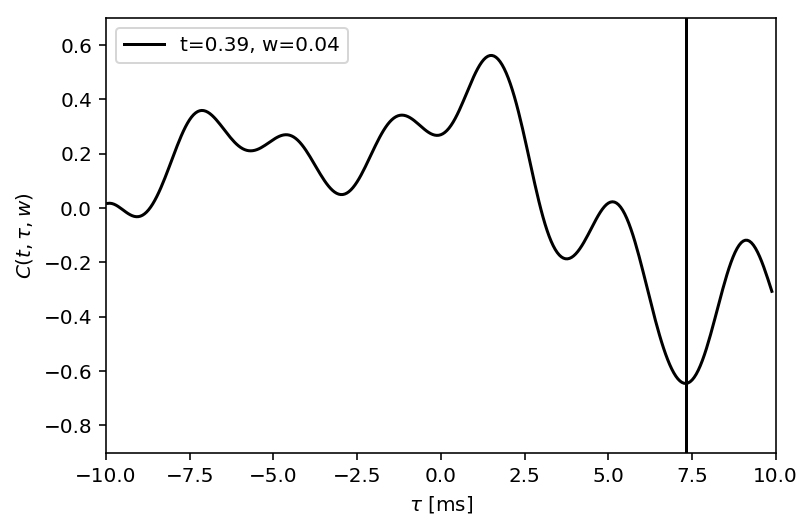

In [137]:
h1_res_times = adjusted_resh1[:,0]; h1_res_strain = adjusted_resh1[:,1]
l1_res_times = adjusted_resl1[:,0]; l1_res_strain = adjusted_resl1[:,1]

fs = 1./(h1_res_times[1]-h1_res_times[0])

t = 0.39
w = 0.04

min_indxt = np.where(abs(h1_res_times-t) == abs(h1_res_times-t).min())[0][0]
max_indxt = np.where(abs(h1_res_times-(t+w)) == abs(h1_res_times-(t+w)).min())[0][0]

deltatau = 0.01

tauind_min = int(-deltatau*fs); tauind_max = int(+deltatau*fs)
tauind = np.arange(tauind_min,tauind_max)
tau = tauind/fs

corr = []

for i in tauind:
    corr.append(np.corrcoef(h1_res_strain[min_indxt+abs(tauind_min)+i:max_indxt-abs(tauind_max)+i],l1_res_strain[min_indxt+abs(tauind_min):max_indxt-abs(tauind_max)])[0][1])
corr = array(corr)
    
imax = argmax(abs(corr))
print('max |corr| = {:.2g} at tau = {:.3g} ms'.format(max(abs(corr)), 1000*tau[imax]))

plt.figure()
plt.plot(tau * 1000.,corr,'k',label="t="+str(t)+", w="+str(w))
plt.axvline(tau[imax]*1000, color='k')
plt.xlim(-10,10)
plt.xlabel(r"$\tau$ [ms]")
plt.ylabel(r"$C(t,\tau,w)$")
plt.ylim(-.9,.7)
plt.legend(loc='best')

## What About Using a Better Template?

See the notebook in the ``LOSC_Event_tutorial`` subdirectory, which performs the calculation using the actual template that found the signal in the search (not quite the best-fitting template, since the template bank is discrete---but close to it).